# Esplorazione e scelta del modello
In questo notebook, riporto in maniera sintetica e semplificata le prove e i risultati che hanno portato alla scelta del migliore modello.
<br>Nella realtà, le idee e gli algoritmi testati sono stati variegati e molteplici. Qui riporto solo i tentativi andati a buon fine.
<br>Tra gli approcci che abbiamo messo alla prova, ricordo anche l'uso dei word embeddings (fastText) e dei language models (varianti di BERT). In ambito NLP, questi modelli ottengono in molti casi performance superiori alle tecniche tradizionali, usando maggiori tempi e risorse computazionali. Nel caso in esame, non hanno fornito buoni risultati, probabilmente perchè il dataset è relativamente piccolo e alcune classi non sono ben distinguibili. Ho ritenuto poco significativo riprodurre in questa sede gli esperimenti falliti.

In [1]:
import pandas as pd
import json
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import random
from sklearn.model_selection import ParameterGrid

In [2]:
# imposto il seed per rendere il notebook riproducibile
random.seed(15)

In [3]:
# leggo training set e test set
df_train=pd.read_csv('./input/train_set.csv')
df_test=pd.read_csv('./input/test_set.csv')

In [4]:
def evaluate(model):
    """Funzione per stampare le metriche di interesse sul dataset di test, in base al modello scelto"""
    print(metrics.classification_report(df_test.Label, model.predict(df_test.Job_offer), digits=5))

## Baseline: TF-IDF + Naive Bayes
Inizio con un modello molto semplice: per rappresentare il testo scelgo TF-IDF; per il classificatore, adotto Naive Bayes

In [5]:
pipe_0 = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB()),
    ])

In [6]:
pipe_0.fit(df_train.Job_offer, df_train.Label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [7]:
evaluate(pipe_0)

                   precision    recall  f1-score   support

   Java Developer    0.68478   0.69231   0.68852        91
       Programmer    0.60638   0.59375   0.60000        96
Software Engineer    0.74359   0.38667   0.50877        75
   System Analyst    0.96667   0.78378   0.86567        74
    Web Developer    0.55844   0.83495   0.66926       103

         accuracy                        0.66743       439
        macro avg    0.71197   0.65829   0.66645       439
     weighted avg    0.69556   0.66743   0.66380       439



Non male, ma possiamo molto migliorare   

## TF-IDF (con bigrammi) + Naive Bayes
Può avere senso considerare anche le sequenza di 2 parole, oltre alle parole singole

In [8]:
pipe_1 = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', MultinomialNB()),
 ])

In [9]:
pipe_1.fit(df_train.Job_offer, df_train.Label)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [10]:
evaluate(pipe_1)

                   precision    recall  f1-score   support

   Java Developer    0.74444   0.73626   0.74033        91
       Programmer    0.73171   0.62500   0.67416        96
Software Engineer    0.84091   0.49333   0.62185        75
   System Analyst    0.96552   0.75676   0.84848        74
    Web Developer    0.55758   0.89320   0.68657       103

         accuracy                        0.71071       439
        macro avg    0.76803   0.70091   0.71428       439
     weighted avg    0.75156   0.71071   0.71124       439



I risultati sono migliorati

## Trattamento parole accorpate
Esaminando il vocabolario di TF-IDF, ci rendiamo conto che esistono alcuni errori nel dataset: parole separate sono state accorpate.
<br> Vediamo qualche esempio:

In [11]:
[w for w in pipe_1.steps[0][1].vocabulary_.keys() if len(w.split())==1 if len(w)>20][:10]

['automobilbranchezusammen',
 'softwareanforderungen',
 'programmazioneflessibilità',
 'telecomunicazioniconoscenze',
 'internazionalizzazione',
 'datawarehouserequisito',
 'indeterminatoretribuzione',
 'indeterminatocategoria',
 'informaticocompetenza',
 'certificazionipossibilità']

Ovviamente gli errori sono fuorvianti e non permettono al modello di recepire il contenuto informativo delle parole accorpate.
<br>Vista l'esiguità del dataset, le correggiamo, usando un dizionario compilato manualmente.
<br>Il problema della separazione di parole accorpate è abbastanza complesso. Esistono trattazioni statistiche basate sull'algoritmo di Viterbi. Tuttavia non sono disponibili librerie che permettono di eseguire out-of-the-box la separazione per la lingua italiana.

In [12]:
# carico il dizionario delle correzioni
with open('./input/correzioni.json') as fin:
    correzioni=json.load(fin)
for i,(k,v) in enumerate(correzioni.items()):
    print(f'{k}: {v}')
    if i==4: break

developerparliamo: developer parliamo
softwaresystemen: software systemen
softwareanforderungen: software anforderungen
softwareentwicklung: software entwicklung
servizimanutenere: servizi manutenere


In [13]:
def divide_words(series):
    """
    Funzione che, applicata alla serie,
    per ogni elemento divide le parole accorpate
    """
    new_sentences=[]
    
    lower_series=series.str.lower()
    for sentence in lower_series:
        new_sentence=sentence
        for composite_word,words in correzioni.items():
            if composite_word in new_sentence:
                new_sentence=new_sentence.replace(composite_word,words)
        new_sentences.append(new_sentence)
    new_series=pd.Series(new_sentences)
    return new_series

In [14]:
pipe_2 = Pipeline([
        ('divide_words', FunctionTransformer(func=divide_words)),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', MultinomialNB()),
 ])

In [15]:
pipe_2.fit(df_train.Job_offer, df_train.Label)

Pipeline(steps=[('divide_words',
                 FunctionTransformer(func=<function divide_words at 0x7ff526467d30>)),
                ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [16]:
evaluate(pipe_2)

                   precision    recall  f1-score   support

   Java Developer    0.74444   0.73626   0.74033        91
       Programmer    0.73750   0.61458   0.67045        96
Software Engineer    0.82609   0.50667   0.62810        75
   System Analyst    0.96552   0.75676   0.84848        74
    Web Developer    0.55758   0.89320   0.68657       103

         accuracy                        0.71071       439
        macro avg    0.76622   0.70149   0.71479       439
     weighted avg    0.75030   0.71071   0.71149       439



C'è stato un piccolo miglioramento...

## Troncamento Job offer lunghe
Ci accorgiamo che nel dataset sono presenti alcuni annunci che, come il seguente, contengono testo superfluo:

In [17]:
# stampo la fine dell'annuncio
print(df_train.loc[4].Job_offer[3500:])

i Almeno 3 anni di esperienza in analoga mansione Ottima conoscenza del linguaggio C#, HTML 5, Sql Server Jquery, Json, Ottima conoscenza di .Net framework 3.5 e successivi Capacità di lavorare in Team Buona capacità di adattamento e flessibilità nel ruolo e nella mansione Capacità di problem solving Orientamento all'obiettivo e al risultato Gradita conoscenza di: Javascript e Bootstrap. Programmazione microcontrollori in C++ Completano il profilo spirito di iniziativa e autonomia nello svolgimento del progetto assegnato Assunzione a tempo indeterminato direttamente da parte del cliente e RAL al di sopra della media del mercato. L'offerta di lavoro si intende rivolta all'uno e all'altro sesso in ottemperanza al D.Lgs. 198/2006.
   Contatta l'utente, Grazie per averci aiutato a far rispettare le regole di pubblicazione degli annunci.
   ×

   Segnalazione già inviata!

   Grazie per averci aiutato a far rispettare le regole di pubblicazione degli annunci.
   ×

   Spiacenti, l'invio del

Analizziamo la distribuzione del numero di parole nel dataset

In [18]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

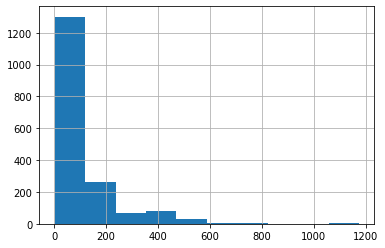

In [19]:
plot_word_number_histogram(df_train['Job_offer'])

Sostanzialmente, la maggior parte degli annunci ha meno di 600 parole. Decidiamo, per ora, che questo deve essere il numero massimo. Successivamente, faremo prove più approfondite.

In [20]:
def truncate_input(series,n_words):
    """
    Funzione che, applicata alla serie,
    per ogni elemento elimina le parole che eccedono n_words
    """
    splitted_series=series.str.split()
    truncated_series=pd.Series([' '.join(word[:n_words]) for word in splitted_series])
    return truncated_series

In [21]:
pipe_3 = Pipeline([
        ('divide_words', FunctionTransformer(func=divide_words)),
        ('trunc_input', FunctionTransformer(func=truncate_input, kw_args={'n_words':600})),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
        ('clf', MultinomialNB()),
 ])

In [22]:
pipe_3.fit(df_train.Job_offer, df_train.Label)

Pipeline(steps=[('divide_words',
                 FunctionTransformer(func=<function divide_words at 0x7ff526467d30>)),
                ('trunc_input',
                 FunctionTransformer(func=<function truncate_input at 0x7ff518767310>,
                                     kw_args={'n_words': 600})),
                ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [23]:
evaluate(pipe_3)

                   precision    recall  f1-score   support

   Java Developer    0.75281   0.73626   0.74444        91
       Programmer    0.73750   0.61458   0.67045        96
Software Engineer    0.82609   0.50667   0.62810        75
   System Analyst    0.96552   0.75676   0.84848        74
    Web Developer    0.56024   0.90291   0.69145       103

         accuracy                        0.71298       439
        macro avg    0.76843   0.70344   0.71659       439
     weighted avg    0.75265   0.71298   0.71349       439



Siamo riusciti a migliorare...

## Riduzione numero features
Entrambi i tentativi precedenti hanno avuto l'effetto di ridurre il numero di features, escludendone alcune non significative.
<br>Esaminiamo la dimensione del vocabolario attuale del TF-IDF:

In [24]:
len(pipe_3.steps[2][1].vocabulary_)

49623

Possiamo ancora ridurre il numero delle features, agendo su due fronti:
* controllando il parametro *max_df* del TF-IDF:<br>vengono escluse le parole che compaiono in più di una certa frazione di documenti, in quanto probabilmente poco significative
* selezionando le features più significative, in base ad un'analisi statistica univariata (*SelectPercentile*)

In [25]:
pipe_4 = Pipeline([
        ('divide_words', FunctionTransformer(func=divide_words)),
        ('trunc_input', FunctionTransformer(func=truncate_input, kw_args={'n_words':600})),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.7)),
        ('select_features', SelectPercentile(score_func=f_classif, percentile=98)),
        ('clf', MultinomialNB()),
 ])

In [26]:
pipe_4.fit(df_train.Job_offer, df_train.Label)

Pipeline(steps=[('divide_words',
                 FunctionTransformer(func=<function divide_words at 0x7ff526467d30>)),
                ('trunc_input',
                 FunctionTransformer(func=<function truncate_input at 0x7ff518767310>,
                                     kw_args={'n_words': 600})),
                ('tfidf', TfidfVectorizer(max_df=0.7, ngram_range=(1, 2))),
                ('select_features', SelectPercentile(percentile=98)),
                ('clf', MultinomialNB())])

In [27]:
evaluate(pipe_4)

                   precision    recall  f1-score   support

   Java Developer    0.75000   0.75824   0.75410        91
       Programmer    0.69880   0.60417   0.64804        96
Software Engineer    0.82609   0.50667   0.62810        75
   System Analyst    0.96610   0.77027   0.85714        74
    Web Developer    0.57862   0.89320   0.70229       103

         accuracy                        0.71526       439
        macro avg    0.76392   0.70651   0.71794       439
     weighted avg    0.74802   0.71526   0.71459       439



Ancora un piccolo miglioramento...
<br>Possiamo provare un algoritmo diverso...

## TF-IDF (con bigrammi) + classificatore SGD
Scelgo una SVM lineare, addestrata con discesa stocastica del gradiente

In [28]:
pipe_5 = Pipeline([
        ('divide_words', FunctionTransformer(func=divide_words)),
        ('trunc_input', FunctionTransformer(func=truncate_input, kw_args={'n_words':600})),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.7)),
        ('select_features', SelectPercentile(score_func=f_classif, percentile=97)),
        ('clf', SGDClassifier()),
 ])

In [29]:
pipe_5.fit(df_train.Job_offer, df_train.Label)

Pipeline(steps=[('divide_words',
                 FunctionTransformer(func=<function divide_words at 0x7ff526467d30>)),
                ('trunc_input',
                 FunctionTransformer(func=<function truncate_input at 0x7ff518767310>,
                                     kw_args={'n_words': 600})),
                ('tfidf', TfidfVectorizer(max_df=0.7, ngram_range=(1, 2))),
                ('select_features', SelectPercentile(percentile=97)),
                ('clf', SGDClassifier())])

In [30]:
evaluate(pipe_5)

                   precision    recall  f1-score   support

   Java Developer    0.80220   0.80220   0.80220        91
       Programmer    0.79348   0.76042   0.77660        96
Software Engineer    0.76471   0.86667   0.81250        75
   System Analyst    0.98571   0.93243   0.95833        74
    Web Developer    0.86139   0.84466   0.85294       103

         accuracy                        0.83599       439
        macro avg    0.84150   0.84127   0.84051       439
     weighted avg    0.83871   0.83599   0.83658       439



Abbiamo guadagnato più di 10 punti percentuali!
<br>Il modello è effettivamente buono.

## Grid search: ricerca del modello migliore
Il modello a cui siamo arrivati ha buone performance.
<br>Gli iperparametri che lo descrivono possono però essere scelti in modo da massimizzare i risultati.
<br>Operiamo quindi una ricerca a griglia: il modello viene addestrato sul dataset, senza early stopping. Solo la valutazione finale della performance avviene sul test set.
<br>*Nota: negli esperimenti reali, abbiamo testato un numero molto maggiore di modelli e di iperparametri. Qui riportiamo una parte della ricerca, al fine di mostrare la tecnica utilizzata*

In [31]:
pipe_6 = Pipeline([
        ('divide_words', FunctionTransformer(func=divide_words)),
        ('trunc_input', FunctionTransformer(func=truncate_input, kw_args={'n_words':600})),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.7)),
        ('select_features', SelectPercentile(score_func=f_classif, percentile=98)),
        ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42,
                            alpha=1e-4, max_iter=20, tol=1e-4, early_stopping=False, n_jobs=3)),
 ])

In [32]:
parameters = {
              'trunc_input__kw_args': [{'n_words':600}, {'n_words':700}],
              'tfidf__max_df':[0.6, 0.7, 0.8, 0.9],
              'select_features__percentile': [x/100 for x in random.sample(range(9000,10000),20)],
              'clf__max_iter':list(range(10,21,1))
              }

In [33]:
import warnings
warnings.filterwarnings('ignore') 

models_list={}

models_parameters=ParameterGrid(parameters)
for i,params in enumerate(models_parameters):
    if i%250==0:
        print('{:.1%}'.format((i+1)/len(list(models_parameters))))
    
    # addestro il modello
    pipe_6.set_params(**params)
    pipe_6.fit(df_train.Job_offer, df_train.Label)
    
    # calcolo le performance
    y_pred_test=pipe_6.predict(df_test.Job_offer)
    f1=metrics.f1_score(df_test.Label, y_pred_test, average='weighted')
    
    models_list[i]=params
    models_list[i]['f1_weighted']=f1

0.1%
14.3%
28.5%
42.7%
56.9%
71.1%
85.3%
99.5%


Vediamo i migliori modelli ottenuti:

In [34]:
models_df=pd.DataFrame.from_dict(models_list, orient='index').sort_values('f1_weighted', ascending=False)
models_df[:5]

,clf__max_iter,select_features__percentile,tfidf__max_df,trunc_input__kw_args,f1_weighted
266,11,96.97,0.7,{'n_words': 600},0.847806
255,11,99.00,0.9,{'n_words': 700},0.845405
253,11,99.00,0.8,{'n_words': 700},0.845405
263,11,98.24,0.9,{'n_words': 700},0.845345
261,11,98.24,0.8,{'n_words': 700},0.845345


Riaddestriamo il migliore modello, per verificarne più ampiamente le performance

In [36]:
best_pipe = Pipeline([
        ('divide_words', FunctionTransformer(func=divide_words)),
        ('trunc_input', FunctionTransformer(func=truncate_input,
                                            kw_args={'n_words':600})),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.7)),
        ('select_features', SelectPercentile(score_func=f_classif, 
                                             percentile=96.97)),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                            alpha=1e-4, max_iter=11, 
                            tol=1e-4, early_stopping=False,
                            random_state=42))
])

In [37]:
%%time
best_pipe.fit(df_train.Job_offer, df_train.Label)

CPU times: user 1.3 s, sys: 104 ms, total: 1.4 s
Wall time: 1.26 s


Pipeline(steps=[('divide_words',
                 FunctionTransformer(func=<function divide_words at 0x7ff526467d30>)),
                ('trunc_input',
                 FunctionTransformer(func=<function truncate_input at 0x7ff518767310>,
                                     kw_args={'n_words': 600})),
                ('tfidf', TfidfVectorizer(max_df=0.7, ngram_range=(1, 2))),
                ('select_features', SelectPercentile(percentile=96.97)),
                ('clf',
                 SGDClassifier(max_iter=11, random_state=42, tol=0.0001))])

In [38]:
evaluate(best_pipe)

                   precision    recall  f1-score   support

   Java Developer    0.81319   0.81319   0.81319        91
       Programmer    0.79787   0.78125   0.78947        96
Software Engineer    0.82278   0.86667   0.84416        75
   System Analyst    0.98551   0.91892   0.95105        74
    Web Developer    0.84906   0.87379   0.86124       103

         accuracy                        0.84738       439
        macro avg    0.85368   0.85076   0.85182       439
     weighted avg    0.84894   0.84738   0.84781       439

